# Consistent Bayes: Examples from the Paper
---

Copyright 2018 Michael Pilosov

Based on work done by ... 

### Import Libraries
_tested with python 3.6 on 02/11/18_

In [1]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
# %matplotlib inline
%matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 10, 5
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *

# Example Summary

---
## Example 6.1

We solve the following nonlinear system:

$$
\lambda_1 \,  x_1^2 + x_2^2 = 1  \\
x_1^2 - \lambda_2 \, x_2^2 = 1
$$

Rearranging the second equation to get $x_1^2 = 1 + \lambda_2 \, x_2^2$, which we substitute into the first equation and perform some rearranging:

$$
\lambda_1 \, ( 1 + \lambda_2 \, x_2^2 ) + x_2^2 = 1 \\
\lambda_1 + \lambda_1 \lambda_2 \, x_2^2 + x_2^2 = 1\\
\lambda_1 + (1 + \lambda_1 \lambda_2) \, x_2^2 = 1 \\
$$

This then leads us to the following solution:
$$
x_1^2 = 1 + \frac{\lambda_2 - \lambda_2 \lambda_1}{1 + \lambda_1 \lambda_2} \\
x_2^2 = \frac{1 - \lambda_1}{1 + \lambda_1 \lambda_2}
$$

Here, $\Lambda = [0.79, 0.99] \times [1 - 4.5\sqrt{0.1}, \,1 + 4.5\sqrt{0.1}]$.  

Our quantity of interest is simply $q(x) = x_2$

We impose **Beta(2, 5)** and **Beta(1, 1)** over the support as our two priors that we investigate for this example.

---
## Example 6.2

Here we have a piecewise-defined function $q: d\to 1$ which is quite convoluted but defined for an abitrary input dimension, though we restrict ourselves to the case where $d = 2$, so $\lambda = (\lambda_1, \lambda_2)$

$$
q(\lambda) = 
\begin{cases} 
q_1(\lambda) - 2 & \text{ if } 3\, \lambda_1 + 2\, \lambda_2 \geq 0 \text{ and } -\lambda_1 + 0.3\, \lambda_2 \lt 0 \\ 
q_2(\lambda) & \text{ if } 3\, \lambda_1 + 2\, \lambda_2 \geq 0 \text{ and } -\lambda_1 + 0.3\, \lambda_2 \geq 0 \\
2\, q_1(\lambda) + 4 & \text{ if } (\lambda_1 + 1)^2 + ( \lambda_2 + 1)^2 \lt 0.95^2 \text{ and } d = 2 \\
q_1(\lambda) & \text{ otherwise }
\end{cases}
$$

where 
$$
q_1(\lambda) = \exp \left (- \sum_{i=1}^{d} \lambda_i^2 \right ) - \lambda_1^3 - \lambda_2^3, \text{ and } \\ 
q_2(\lambda) = 1 + q_1(\lambda) + \frac{1}{4d} \sum_{i=1}^{d} \lambda_i^2
$$


Here, $\Lambda = [-1, 1]^2$ and we use **Beta(1,1)** over the support as our prior.

---
## Define Functions

In [2]:
def fun1(lam):
    if lam.shape[1] != 2:
        raise(AttributeError('Your lambda must be two-dimensional'))
    # our QoI here is just x_2. 
    numerator = 1.0 - lam[:,0]
    denominator = 1 + np.product(lam, axis=1)
    return np.sqrt(np.divide(numerator, denominator))

def q1(lam):
    L1 = lam[:,0] # local column-vectors.
    L2 = lam[:,1]
    ell2 = np.linalg.norm(lam, axis=1) # ell^2 norm (euclidean) for convenience later.
    return np.exp(-ell2) - L1**3 - L2**3
     
def q2(lam):
    d = lam.shape[1]
    L1 = lam[:,0] # local column-vectors.
    L2 = lam[:,1]
    ell2 = np.linalg.norm(lam, axis=1) # ell^2 norm (euclidean) for convenience later.
    return 1.0 + q1(lam) + 0.25*d*ell2
    
def fun2(lam):
    n = lam.shape[0]
    d = lam.shape[1] # get dimension. Should check for conformity to size, but we'll just assume it's right.
    L1 = lam[:,0] # give first two columns names for convenience 
    L2 = lam[:,1] # later when we define our conditional statements.
    
    # now let's figure out how to partition our space up... 
    inds1 = np.where( (3*L1 + 2*L2 >= 0) & (-L1 + 0.3*L2 < 0) )[0] # this weird syntax is because of `np.where`
    inds2 = np.where( (3*L1 + 2*L2 >= 0) & (-L1 + 0.3*L2 >= 0) )[0]
    
    if d == 2:
        inds3 = np.where( ( (L1 + 1.0)**2 + (L2 + 1.0)**2 ) < 0.95**2 )[0]
        inds4 = np.where( (3*L1 + 2*L2 < 0) & ( (L1 + 1.0)**2 + (L2 + 1.0)**2  > 0.95**2) )[0]
    else:
        inds3 = [] # if d != 2, this map 
        inds4 = np.where( (3*L1 + 2*L2 < 0) )[0]
        
    output = np.zeros(n)
    output[inds1] = q1(lam[inds1,:]) - 2.0
    output[inds2] = q2(lam[inds2,:])
    output[inds3] = 2*q1(lam[inds3,:]) + 4.0
    output[inds4] = q1(lam[inds4,:])
    return output

--- 

# Sample from Prior


In [3]:
PtO_fun_choice = 2
dist = 'beta' # for example 6.1. Ex 6.2 uses uniform.

input_dim = 2 # Specify input space dimension (n)
num_samples = int(5E3) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))

if PtO_fun_choice == 1:
    PtO_fun = fun1
    if dist == 'beta':
        s_set.set_dist('beta', kwds={'a': 2, 'b': 5, 'loc': 0.79, 'scale': 0.20}, dim=0)
        s_set.set_dist('beta', kwds={'a': 2, 'b': 5, 'loc': 1-4.5*np.sqrt(0.1), 'scale': 9*np.sqrt(0.1)}, dim=1)
    elif dist == 'uni':
        s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0.79, 'scale': 0.20}, dim=0)
        s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 1-4.5*np.sqrt(0.1), 'scale': 9*np.sqrt(0.1)}, dim=1)

elif PtO_fun_choice == 2:
    PtO_fun = fun2
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -1, 'scale': 2}, dim=0)
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -1, 'scale': 2}, dim=1)

s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [4]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
                    N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
                    eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
                    view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
                    view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [5]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

dimensions :  lambda = (5000, 2)   D = (5000, 1)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [6]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [46]:
# pf_dist.kde_object.set_bandwidth(1E-10

import numpy as np

In [50]:
X = p_set.output.samples
kk = KernelDensity(kernel='epanechnikov').fit(X)

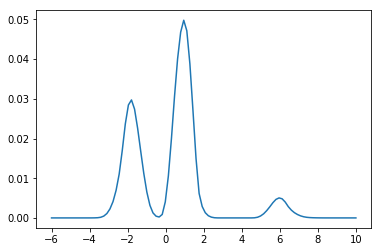

In [52]:
xx = np.linspace(-6,10,100).reshape(-1,1)
Y = kk.score_samples(xx)
plt.plot(xx,10**Y)

In [9]:
output_dim = p_set.output.dim
widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=10000, min = 100, max=10000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=10000, continuous_update=False, description='N', max=10000, min=100, step=100), Text(value='brown', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

# Define Observed Probability Measure $P_\mathcal{D}$

In [ ]:
if PtO_fun_choice == 1:
    p_set.set_observed_dist('normal', {'loc':0.3, 'scale':0.025}) # default is normal based on the data space # for function choice = 1

elif PtO_fun_choice == 2:
    p_set.set_observed_dist('normal', {'loc':-2.0, 'scale':0.25**2}) # default is normal based on the data space # for function choice = 1


obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [ ]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [ ]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


In [ ]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.


---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [ ]:
widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

## Pushforward of Posterior:

In [ ]:
widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [ ]:
[np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

In [ ]:
[p_set.observed_dist.mean(), p_set.observed_dist.std()]

They look pretty good! Now go back to the [Sampling Section](#Sample-from-Prior) and change the distribution on the prior or choose another example problem.